# Import Dataset

In [1]:
from glob import glob
import os

# dataset directories
parent_train_dir = "data/original/training"
parent_test_dir = "data/original/test"

# import image paths
parent_train_image_paths = sorted(glob(os.path.join(parent_train_dir, "*.jpg")))
parent_test_image_paths = sorted(glob(os.path.join(parent_test_dir, "*.jpg")))

# print number of images
print(f"Loaded {len(parent_train_image_paths)} training images")
print(f"Loaded {len(parent_test_image_paths)} test images")


Loaded 88 training images
Loaded 22 test images


# Label Data

In [2]:
# This gives you real labels from filenames like 016z050pf.jpg
def get_training_labels(image_paths):
    labels = []
    for path in image_paths:
        filename = os.path.basename(path)
        subject_id = filename.split('z')[1][:3]  # Extract '050'
        labels.append(subject_id)
    return labels

train_labels = get_training_labels(parent_train_image_paths)
print("Train Labels:", train_labels)

test_label_map = {
    'DSC00165.JPG': '001',
    'DSC00166.JPG': '001',
    'DSC00167.JPG': '002',
    'DSC00168.JPG': '002',
    'DSC00169.JPG': '003',
    'DSC00170.JPG': '003',
    'DSC00171.JPG': '004',
    'DSC00172.JPG': '004',
    'DSC00173.JPG': '005',
    'DSC00174.JPG': '005',
    'DSC00175.JPG': '006',
    'DSC00176.JPG': '006',
    'DSC00177.JPG': '007',
    'DSC00178.JPG': '007',
    'DSC00179.JPG': '008',
    'DSC00180.JPG': '008',
    'DSC00181.JPG': '009',
    'DSC00182.JPG': '009',
    'DSC00183.JPG': '010',
    'DSC00184.JPG': '010',
    'DSC00185.JPG': '011',
    'DSC00186.JPG': '011'
}

test_labels = [test_label_map[os.path.basename(path)] for path in parent_test_image_paths]
print("Test Labels:", test_labels)


Train Labels: ['050', '050', '051', '051', '052', '052', '053', '053', '054', '054', '055', '055', '056', '056', '057', '057', '058', '058', '059', '059', '060', '060', '061', '061', '062', '062', '063', '063', '064', '064', '065', '065', '066', '066', '067', '067', '068', '068', '069', '069', '070', '070', '071', '071', '072', '072', '001', '001', '002', '002', '003', '003', '004', '004', '005', '005', '006', '006', '007', '007', '008', '008', '009', '009', '010', '010', '073', '073', '074', '074', '075', '075', '076', '076', '077', '077', '078', '078', '079', '079', '080', '080', '081', '081', '082', '082', '011', '011']
Test Labels: ['001', '001', '002', '002', '003', '003', '004', '004', '005', '005', '006', '006', '007', '007', '008', '008', '009', '009', '010', '010', '011', '011']


# Pre-processing

In [3]:
## manual silhouette extraction
import cv2
import numpy as np
from concurrent.futures import ThreadPoolExecutor

def get_green_screen_region_mask(image_shape):
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    x1, y1 = 700, 275
    x2, y2 = 1700, 1590
    mask[y1:y2, x1:x2] = 255
    return mask

def extract_largest_human_contour(binary_mask):
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return binary_mask

    best_contour = None
    max_score = 0
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = cv2.contourArea(cnt)
        aspect_ratio = h / (w + 1e-5)
        score = area * aspect_ratio
        if score > max_score:
            max_score = score
            best_contour = cnt

    cleaned = np.zeros(binary_mask.shape, dtype=np.uint8)
    if best_contour is not None:
        cv2.drawContours(cleaned, [best_contour], -1, 255, thickness=cv2.FILLED)
    return cleaned

def preprocess_image(image_path, output_dir, size=(640, 480)):
    try:
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to load {image_path}")
            return

        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        lower_green = np.array([45, 100, 50])
        upper_green = np.array([75, 255, 255])
        green_mask = cv2.inRange(hsv, lower_green, upper_green)
        silhouette_mask = cv2.bitwise_not(green_mask)

        region_mask = get_green_screen_region_mask(image.shape)
        masked = cv2.bitwise_and(silhouette_mask, silhouette_mask, mask=region_mask)

        kernel = np.ones((5, 5), np.uint8)
        masked = cv2.morphologyEx(masked, cv2.MORPH_CLOSE, kernel)

        cleaned = extract_largest_human_contour(masked)
        cleaned = cv2.resize(cleaned, size)

        os.makedirs(output_dir, exist_ok=True)
        filename = os.path.basename(image_path)
        save_path = os.path.join(output_dir, filename)
        cv2.imwrite(save_path, cleaned)

    except Exception as e:
        print(f"Error processing {image_path}: {e}")


def preprocess_images_multithreaded(image_paths, output_dir, max_workers=12):
    os.makedirs(output_dir, exist_ok=True)
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(executor.map(lambda path: preprocess_image(path, output_dir), image_paths))

# Example usage
preprocess_images_multithreaded(parent_train_image_paths, "data/manual/training")
preprocess_images_multithreaded(parent_test_image_paths, "data/manual/test")


In [4]:
## deeplab silhouettes
import os
import cv2
import torch
import torchvision
import numpy as np
from torchvision import transforms
from concurrent.futures import ThreadPoolExecutor

# Load model on GPU once
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True).eval().cuda()

# Image preprocessor
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((520, 520)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def segment_and_save(image_path, output_dir, size=(640, 480)):
    try:
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to load {image_path}")
            return

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        input_tensor = preprocess(image_rgb).unsqueeze(0).cuda()

        with torch.no_grad():
            output = model(input_tensor)['out'][0]
        pred = output.argmax(0).byte().cpu().numpy()

        # Extract person class (15 in COCO)
        person_mask = (pred == 15).astype(np.uint8) * 255
        person_mask = cv2.resize(person_mask, size, interpolation=cv2.INTER_NEAREST)

        # Save
        filename = os.path.basename(image_path)
        save_path = os.path.join(output_dir, filename)
        cv2.imwrite(save_path, person_mask)
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

def process_dataset(input_dir, output_dir, max_workers=8):
    os.makedirs(output_dir, exist_ok=True)
    image_paths = [os.path.join(input_dir, f)
                   for f in os.listdir(input_dir) if f.lower().endswith(('.jpg'))]

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        for path in image_paths:
            executor.submit(segment_and_save, path, output_dir)

process_dataset("data/original/training", "data/deeplab/training")
process_dataset("data/original/test", "data/deeplab/test")


c:\Users\tomev\anaconda3\envs\biometrics\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\tomev\anaconda3\envs\biometrics\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
## augmentation
import os
from PIL import Image, ImageOps
from torchvision import transforms
from tqdm import tqdm
import random

# === Settings ===
input_dir = "data/deeplab/training"  # or deeplab/test
output_dir = "data/deeplab/training_augmented"
augmentation_rate = 2  # Adjust this value to control the rate of augmentation

if os.path.exists(output_dir):
    for file in os.listdir(output_dir):
        os.remove(os.path.join(output_dir, file))
else:
    os.makedirs(output_dir, exist_ok=True)

# === Augmentations ===
augmentations = [
    ("flip", transforms.RandomHorizontalFlip(p=1)),
    #("rotate", transforms.RandomRotation(degrees=5)),
    ("shift", transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)))
]

# === Process Images ===
for filename in tqdm(os.listdir(input_dir)):
    if not filename.lower().endswith(('.jpg', '.png')):
        continue
    path = os.path.join(input_dir, filename)
    image = Image.open(path).convert("L")

    # Save original
    image.save(os.path.join(output_dir, filename))

    # Apply augmentations
    for name, aug in augmentations:
        if random.random() < augmentation_rate:
            transformed = aug(image)
            new_name = f"{os.path.splitext(filename)[0]}_{name}.jpg"
            transformed.save(os.path.join(output_dir, new_name))
        
# re-label augmented images
augmented_image_paths = sorted(glob(os.path.join(output_dir, "*.jpg")))
aug_train_labels = get_training_labels(augmented_image_paths)

print(len(augmented_image_paths), " images in augmented dataset")

100%|██████████| 88/88 [00:01<00:00, 65.13it/s]

264  images in augmented dataset


# Visualistation

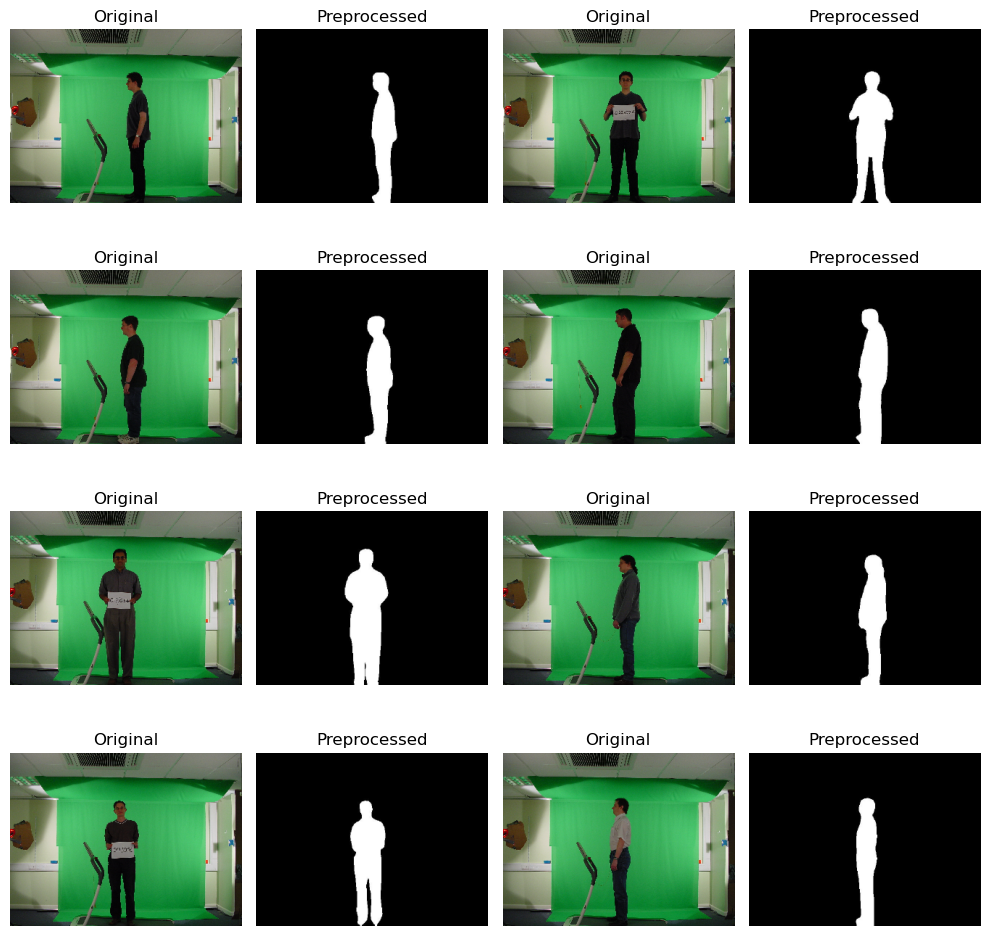

In [6]:
import random
import cv2
import matplotlib.pyplot as plt
import os

def show_preprocessed_examples_from_disk(original_paths, processed_dir, num=2, size=(320, 240)):
    """Displays original and processed silhouette images (loaded from disk) in a side-by-side grid."""
    pairs_per_row = 2
    rows = (num + pairs_per_row - 1) // pairs_per_row

    plt.figure(figsize=(10, rows * 2.5))
    indices = random.sample(range(len(original_paths)), min(num, len(original_paths)))

    for i, idx in enumerate(indices):
        row_offset = (i // pairs_per_row) * (pairs_per_row * 2)
        col_offset = (i % pairs_per_row) * 2

        # Load original
        original = cv2.imread(original_paths[idx])
        original = cv2.cvtColor(cv2.resize(original, size), cv2.COLOR_BGR2RGB)

        # Load processed by matching filename
        filename = os.path.basename(original_paths[idx])
        processed_path = os.path.join(processed_dir, filename)
        processed = cv2.imread(processed_path, cv2.IMREAD_GRAYSCALE)
        processed = cv2.resize(processed, size)

        # Original image
        plt.subplot(rows, pairs_per_row * 2, row_offset + col_offset + 1)
        plt.imshow(original)
        plt.title("Original")
        plt.axis('off')

        # Processed image
        plt.subplot(rows, pairs_per_row * 2, row_offset + col_offset + 2)
        plt.imshow(processed, cmap='gray')
        plt.title("Preprocessed")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

#show_preprocessed_examples_from_disk(parent_train_image_paths, "data/manual/training")
#show_preprocessed_examples_from_disk(parent_test_image_paths, "data/manual/test")
#show_preprocessed_examples_from_disk(parent_train_image_paths, "data/deeplab/training")
#show_preprocessed_examples_from_disk(parent_test_image_paths, "data/deeplab/test")

show_preprocessed_examples_from_disk(parent_train_image_paths, "data/deeplab/training_augmented", num=8)

# Feature Extraction

In [7]:
## binned techniques
"""
# Hu Moments
if use_hu:
    moments = cv2.moments(binary)
    hu = cv2.HuMoments(moments).flatten()
    features.extend(hu)

# Fourier Descriptors
if use_fourier:
    cnt = contour.squeeze()
    if len(cnt.shape) == 1:  # safety check
        cnt = cnt[np.newaxis, :]
    complex_cnt = cnt[:, 0] + 1j * cnt[:, 1]
    fourier = fft(complex_cnt)
    desc = np.abs(fourier[:num_fourier])
    features.extend(desc)
    
  # Aspect ratio
    if use_aspect:
        x, y, w, h = cv2.boundingRect(contour)
        aspect = h / (w + 1e-5)
        features.append(aspect)

 # height profile
    if use_height:
        h, w = binary.shape
        cols = np.linspace(0, w - 1, num_height_samples, dtype=int)
        height_profile = []
        for x in cols:
            col = binary[:, x]
            y = np.where(col > 0)[0]
            height = y[-1] - y[0] if len(y) > 1 else 0
            height_profile.append(height)
        features.extend(height_profile)

    """

'\n# Hu Moments\nif use_hu:\n    moments = cv2.moments(binary)\n    hu = cv2.HuMoments(moments).flatten()\n    features.extend(hu)\n\n# Fourier Descriptors\nif use_fourier:\n    cnt = contour.squeeze()\n    if len(cnt.shape) == 1:  # safety check\n        cnt = cnt[np.newaxis, :]\n    complex_cnt = cnt[:, 0] + 1j * cnt[:, 1]\n    fourier = fft(complex_cnt)\n    desc = np.abs(fourier[:num_fourier])\n    features.extend(desc)\n    \n  # Aspect ratio\n    if use_aspect:\n        x, y, w, h = cv2.boundingRect(contour)\n        aspect = h / (w + 1e-5)\n        features.append(aspect)\n\n # height profile\n    if use_height:\n        h, w = binary.shape\n        cols = np.linspace(0, w - 1, num_height_samples, dtype=int)\n        height_profile = []\n        for x in cols:\n            col = binary[:, x]\n            y = np.where(col > 0)[0]\n            height = y[-1] - y[0] if len(y) > 1 else 0\n            height_profile.append(height)\n        features.extend(height_profile)\n\n    '

In [8]:
import cv2
import numpy as np
from scipy.fft import fft

def extract_features(image, 
                     use_hu=False,
                     use_fourier=False, num_fourier=10, 
                     use_width=False, num_width_samples=20,
                     use_height=False, num_height_samples=20,
                     use_area=False, use_perimeter=False, use_compactness=False, use_dispersion=False,
                     use_aspect=False):
    
    features = []

    # Ensure binary image
    _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

    # Get main contour
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return np.zeros(1)  # fallback if image is empty
    contour = max(contours, key=cv2.contourArea)   

    # Width profile
    if use_width:
        h, w = binary.shape
        rows = np.linspace(0, h - 1, num_width_samples, dtype=int)
        width_profile = []
        for y in rows:
            row = binary[y, :]
            x = np.where(row > 0)[0]
            width = x[-1] - x[0] if len(x) > 1 else 0
            width_profile.append(width)
        features.extend(width_profile)

    # area
    if use_area:
        area = cv2.contourArea(contour)
        features.append(area)
    
    # perimeter
    if use_perimeter:
        perimeter = cv2.arcLength(contour, closed=True)
        features.append(perimeter)
    
    # compactness
    if use_compactness:
        compactness = (4 * np.pi * area) / (perimeter ** 2 + 1e-5)
        features.append(compactness)

    #dispersion
    if use_dispersion:
        M = cv2.moments(contour)
        cx = int(M["m10"] / (M["m00"] + 1e-5))
        cy = int(M["m01"] / (M["m00"] + 1e-5))
        dispersion = max(np.sqrt((pt[0][0] - cx)**2 + (pt[0][1] - cy)**2) for pt in contour)
        features.append(dispersion)

    return np.array(features, dtype=np.float32)

def extract_features_from_dataset(image_paths, feature_func, **kwargs):
    import cv2
    import numpy as np

    X = []
    for path in image_paths:
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Could not read: {path}")
            continue
        features = feature_func(image, **kwargs)
        X.append(features)
    return np.array(X, dtype=np.float32)


# Classification

In [40]:
# dataset directories
train_dir = "data/deeplab/training"
aug_train_dir = "data/deeplab/training_augmented"
test_dir = "data/deeplab/test"

# import image paths
train_image_paths = sorted(glob(os.path.join(train_dir, "*.jpg")))
aug_train_image_paths = sorted(glob(os.path.join(aug_train_dir, "*.jpg")))
test_image_paths = sorted(glob(os.path.join(test_dir, "*.jpg")))

kwargs = {'use_hu': False, 
          'use_fourier': False, 
          'use_width': True, 'num_width_samples': 100,
          'use_height': False, 'num_height_samples': 100,
          'use_area': False, 'use_perimeter': False, 'use_compactness': False, 'use_dispersion': False,
          'use_aspect': False}

X_train = extract_features_from_dataset(train_image_paths, extract_features, **kwargs)
X_aug_train = extract_features_from_dataset(aug_train_image_paths, extract_features, **kwargs)
X_test = extract_features_from_dataset(test_image_paths, extract_features, **kwargs)

print("Train features shape:", X_train.shape)
print("Augmented Train features shape:", X_aug_train.shape) 

Train features shape: (88, 100)
Augmented Train features shape: (264, 100)


In [30]:
## pytorch CNN
def train_cnn_classifier(train_image_paths, train_labels, test_image_paths, test_labels, label_encoder, epochs):
    import os
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.utils.data import Dataset, DataLoader
    from torchvision import transforms
    from PIL import Image
    from sklearn.preprocessing import LabelEncoder
    torch.manual_seed(42)
    
    # --- Custom Dataset ---
    class SilhouetteDataset(Dataset):
        def __init__(self, image_paths, labels, transform=None):
            self.image_paths = image_paths
            self.labels = labels
            self.transform = transform
            self.label_encoder = label_encoder
            self.encoded_labels = self.label_encoder.transform(labels)

        def __len__(self):
            return len(self.image_paths)

        def __getitem__(self, idx):
            img = Image.open(self.image_paths[idx]).convert("L")
            if self.transform:
                img = self.transform(img)
            return img, self.encoded_labels[idx]

    # --- CNN Model ---
    class SilhouetteCNN(nn.Module):
        def __init__(self, num_classes):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
            self.pool = nn.MaxPool2d(2, 2)
            self.fc1 = nn.Linear(8 * 64 * 32, num_classes)  # 128x64 → 64x32 after pooling

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))  # [B, 8, 64, 32]
            x = x.view(x.size(0), -1)             # flatten
            x = self.fc1(x)                       # [B, num_classes]
            return x

    # --- Transform ---
    transform = transforms.Compose([
        transforms.Resize((128, 64)),
        transforms.ToTensor()
    ])

    # --- Datasets and Loaders ---
    train_ds = SilhouetteDataset(train_image_paths, train_labels, transform)
    test_ds = SilhouetteDataset(test_image_paths, test_labels, transform)

    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=1)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    num_classes = len(set(train_labels))
    model = SilhouetteCNN(num_classes).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    # --- Train ---
    model.train()
    for epoch in range(epochs):
        correct = 0
        total = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Track accuracy
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        if epoch % 5 == 4:
           train_acc = correct / total
           print(f"Epoch {epoch+1}, Train Acc: {train_acc:.3f}")
           
           
    # --- Evaluate ---
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            y_true.append(labels.item())
            y_pred.append(preds.item())

    # Decode labels back to strings
    le = train_ds.label_encoder
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    return y_pred_labels

In [47]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

def classify(X_train, train_labels, X_test, test_labels):
    # Encode labels to numbers
    le = LabelEncoder()
    y_train_enc = le.fit_transform(train_labels)
    y_test_enc = le.transform(test_labels)

    # scale for some models 
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    def evaluate_model(model, name, X_train_local=None, X_test_local=None):
        X_tr = X_train_local if X_train_local is not None else X_train
        X_te = X_test_local if X_test_local is not None else X_test

        model.fit(X_tr, y_train_enc)
        y_pred_enc = model.predict(X_te)
        y_pred = le.inverse_transform(y_pred_enc)
        accuracy = accuracy_score(test_labels, y_pred)
        fill = " " if (accuracy * 22) < 10 else ""
        print(f"{fill}{int(accuracy * len(test_labels))}/{len(test_labels)} - {accuracy:.3f} : {name}")
        return y_pred

    # --- Standard k-NN ---
    knn = KNeighborsClassifier(n_neighbors=6)
    y_pred_best = evaluate_model(knn, "k-NN")

    # --- SVM ---
    svm = SVC(kernel='linear', C=1, gamma='scale', max_iter=10000)  # gamma='scale' is usually fine
    y_pred = evaluate_model(svm, "SVM")

    # --- SGD --- 
    sgd = SGDClassifier(max_iter=1000, tol=1e-3)
    y_pred = evaluate_model(sgd, "SGD")

    # --- Random Forest ---
    rf = RandomForestClassifier(n_estimators=120, random_state=42)
    y_pred = evaluate_model(rf, "Random Forest")

    # --- Logistic Regression ---
    logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
    y_pred = evaluate_model(logreg, "Logistic Regression", X_train_scaled, X_test_scaled)

    # --- Naive Bayes ---
    gnb = GaussianNB()
    y_pred = evaluate_model(gnb, "Gaussian Naive Bayes", X_train, X_test)

    # --- Decision Tree --- 
    dtree = DecisionTreeClassifier(max_depth=100, random_state=42) # play with depth
    y_pred = evaluate_model(dtree, "Decision Tree")

    # --- MLP ---
    mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
    y_pred = evaluate_model(mlp, "MLP", X_train_scaled, X_test_scaled)

    ## --- Custom Pytorch CNN ---
    #print("\nPytorch CNN")
    #y_pred_cnn = train_cnn_classifier(train_image_paths, train_labels,
    #                                test_image_paths, test_labels, le, 30)
    #accuracy = accuracy_score(test_labels, y_pred_cnn)
    #fill = " " if (accuracy * 22) < 10 else ""
    #print(f"{fill}{int(accuracy * len(test_labels))}/{len(test_labels)} - {accuracy:.3f} : CNN")
    
    print()
    return y_pred_best

y_pred = classify(X_train, train_labels, X_test, test_labels)
y_pred_aug = classify(X_aug_train, aug_train_labels, X_test, test_labels)


13/22 - 0.591 : k-NN
 8/22 - 0.364 : SVM
 3/22 - 0.136 : SGD
11/22 - 0.500 : Random Forest
 9/22 - 0.409 : Logistic Regression
 8/22 - 0.364 : Gaussian Naive Bayes
 5/22 - 0.227 : Decision Tree
 8/22 - 0.364 : MLP

14/22 - 0.636 : k-NN
 8/22 - 0.364 : SVM
 5/22 - 0.227 : SGD
 9/22 - 0.409 : Random Forest
 8/22 - 0.364 : Logistic Regression
 1/22 - 0.045 : Gaussian Naive Bayes
 5/22 - 0.227 : Decision Tree
 6/22 - 0.273 : MLP



# Evaluation

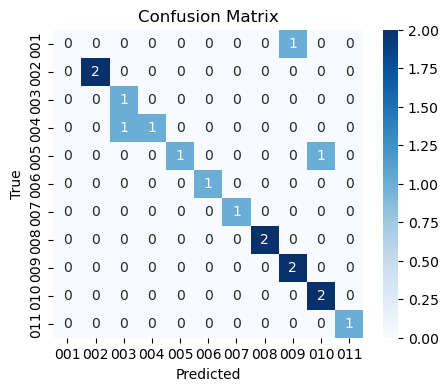

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def show_confusion_matrix(true_labels, pred_labels):
    cm = confusion_matrix(true_labels, pred_labels, labels=sorted(set(true_labels)))
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=sorted(set(true_labels)),
                yticklabels=sorted(set(true_labels)),
                cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

show_confusion_matrix(test_labels, y_pred_aug)

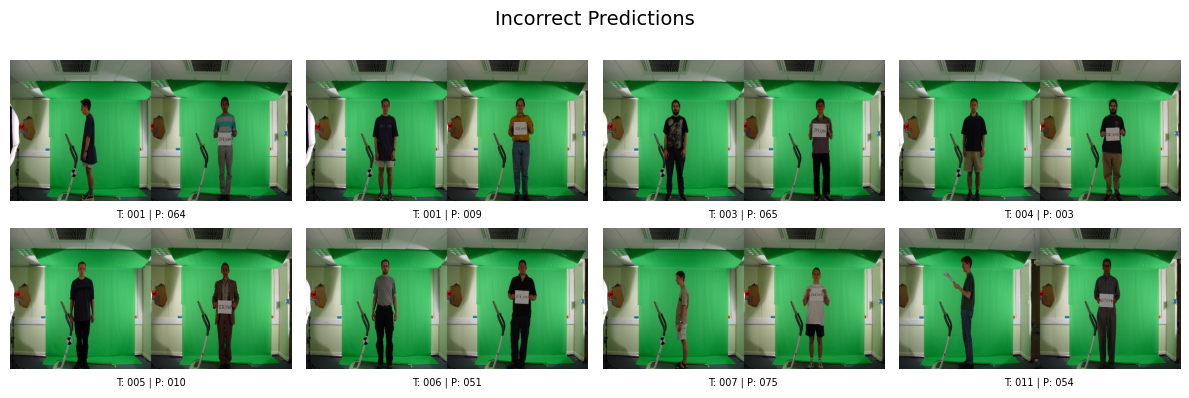

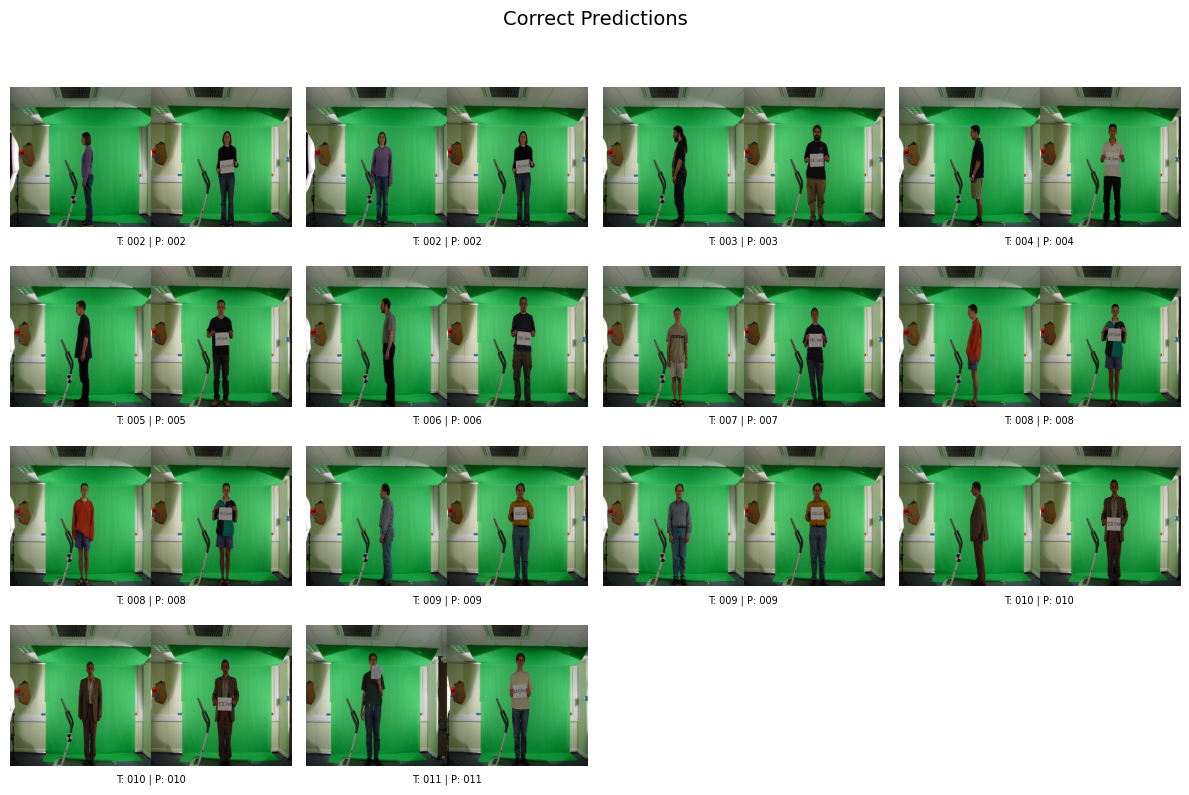

In [49]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import math

def show_prediction_grid_grouped(test_paths, test_labels, pred_labels, train_paths, train_labels, size=(512, 512), columns=4):
    correct_pairs = []
    incorrect_pairs = []

    for i in range(len(test_paths)):
        pred_label = pred_labels[i]
        true_label = test_labels[i]

        if pred_label in train_labels:
            match_index = train_labels.index(pred_label)
            pred_img_path = train_paths[match_index]
        else:
            pred_img_path = None

        pair = (test_paths[i], pred_img_path, true_label, pred_label)
        (correct_pairs if true_label == pred_label else incorrect_pairs).append(pair)

    def plot_pairs(pairs, title):
        n = len(pairs)
        rows = (n + columns - 1) // columns

        fig = plt.figure(figsize=(columns * 3, rows * 2))
        plt.suptitle(title, fontsize=14)

        for i, (test_path, pred_path, true_label, pred_label) in enumerate(pairs):
            row = i // columns
            col = i % columns
            pos = col + row * columns + 1  # subplot index (1-based)

            ax = fig.add_subplot(rows, columns, pos)

            # Load test and pred images
            test_img = cv2.imread(test_path)
            test_img = cv2.cvtColor(cv2.resize(test_img, size), cv2.COLOR_BGR2RGB)

            if pred_path and os.path.exists(pred_path):
                pred_img = cv2.imread(pred_path)
                pred_img = cv2.cvtColor(cv2.resize(pred_img, size), cv2.COLOR_BGR2RGB)
            else:
                pred_img = np.zeros((size[1], size[0], 3), dtype=np.uint8)

            combined = np.hstack((test_img, pred_img))
            ax.imshow(combined)
            ax.text(0.5, -0.12, f"T: {true_label} | P: {pred_label}", ha='center', fontsize=7, transform=ax.transAxes)
            ax.axis('off')

        plt.tight_layout()
        plt.subplots_adjust(top=0.90)
        plt.show()

    if incorrect_pairs:
        plot_pairs(incorrect_pairs, "Incorrect Predictions")
    if correct_pairs:
        plot_pairs(correct_pairs, "Correct Predictions")
 


show_prediction_grid_grouped(
    parent_test_image_paths, test_labels, y_pred_aug,
    parent_train_image_paths, train_labels
)

# Report Specific metrics 

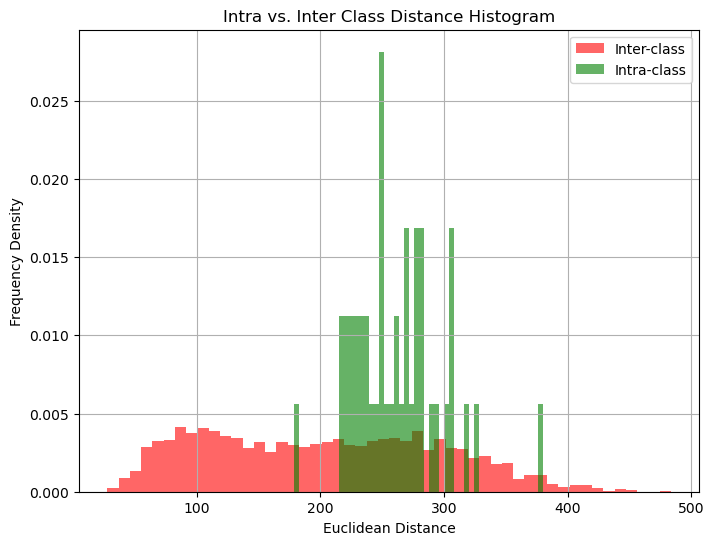

In [34]:
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt

def compute_intra_inter_distances(features, labels):
    intra_dists = []
    inter_dists = []

    for i, j in combinations(range(len(features)), 2):
        dist = np.linalg.norm(features[i] - features[j])
        if labels[i] == labels[j]:
            intra_dists.append(dist)
        else:
            inter_dists.append(dist)

    return np.array(intra_dists), np.array(inter_dists)

def plot_intra_inter_histogram(intra_dists, inter_dists):
    plt.figure(figsize=(8, 6))
    plt.hist(inter_dists, bins=50, alpha=0.6, label='Inter-class', color='red', density=True)
    plt.hist(intra_dists, bins=50, alpha=0.6, label='Intra-class', color='green', density=True)

    plt.title("Intra vs. Inter Class Distance Histogram")
    plt.xlabel("Euclidean Distance")
    plt.ylabel("Frequency Density")
    plt.legend()
    plt.grid(True)
    plt.show()

intra, inter = compute_intra_inter_distances(X_train, train_labels)
plot_intra_inter_histogram(intra, inter)


In [35]:
from itertools import combinations
import numpy as np

def generate_verification_pairs(features, labels):
    distances = []
    is_same = []

    for i, j in combinations(range(len(features)), 2):
        dist = np.linalg.norm(features[i] - features[j])
        label = 1 if labels[i] == labels[j] else 0
        distances.append(dist)
        is_same.append(label)

    return np.array(distances), np.array(is_same)

from sklearn.metrics import roc_curve

def compute_eer_and_ccr(distances, labels_binary):
    # Invert distances so that higher score = more likely same
    fpr, tpr, thresholds = roc_curve(labels_binary, -distances)
    fnr = 1 - tpr

    # EER = where FAR (fpr) == FRR (fnr)
    eer_index = np.nanargmin(np.abs(fpr - fnr))
    eer = fpr[eer_index]
    eer_threshold = thresholds[eer_index]

    # CCR at EER = how many we got right using that threshold
    predictions = (distances < -eer_threshold).astype(int)
    correct = (predictions == labels_binary).sum()
    total = len(labels_binary)
    ccr_at_eer = correct / total

    print(f"\n📊 Equal Error Rate (EER): {eer:.4f}")
    print(f"📈 Threshold at EER: {-eer_threshold:.4f}")
    print(f"✅ CCR at EER: {ccr_at_eer:.4f}")

    return eer, -eer_threshold, ccr_at_eer

distances, is_same = generate_verification_pairs(X_train, train_labels)
eer, threshold, ccr_at_eer = compute_eer_and_ccr(distances, is_same)



📊 Equal Error Rate (EER): 0.6488
📈 Threshold at EER: 247.2610
✅ CCR at EER: 0.3514
